In [43]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
iris_data = load_iris()

In [3]:
iris_data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
columns = iris_data["feature_names"]

In [5]:
df = pd.DataFrame(iris_data.data, columns=columns)

In [6]:
df["target"] = iris_data.target

In [7]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [8]:
iris_data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

# 【課題1】練習のために特徴量とカテゴリを選択
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

virgicolorとvirginica

sepal_lengthとpetal_length

《実際の問題では？》

実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [9]:
#virgicolorとvirginica
vv = df[df["target"] != 0]
vv

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [10]:
#sepal_lengthとpetal_length
sl_pl = vv[["sepal length (cm)", "petal length (cm)"]]
y = vv["target"]

display(sl_pl)
display(y)

,sepal length (cm),petal length (cm)
50,7.0,4.7
51,6.4,4.5
52,6.9,4.9
53,5.5,4.0
54,6.5,4.6
...,...,...
145,6.7,5.2
146,6.3,5.0
147,6.5,5.2
148,6.2,5.4


50     1
51     1
52     1
53     1
54     1
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 100, dtype: int64

 # 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

《実際の問題では？》

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

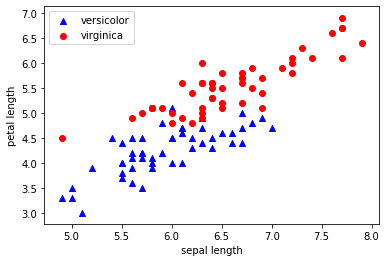

In [59]:
#散布図
plt.scatter(sl_pl[y==1].iloc[:, 0], sl_pl[y==1].iloc[:, 1], label="versicolor", marker="^", color="b")
plt.scatter(sl_pl[y==2].iloc[:, 0], sl_pl[y==2].iloc[:, 1], label="virginica", color="r")
plt.legend(loc='upper left')
plt.xlabel("sepal length")
plt.ylabel("petal length")
plt.show()

In [58]:
#箱ひげ図
df_data = vv[["sepal length (cm)", "petal length (cm)", "target"]]

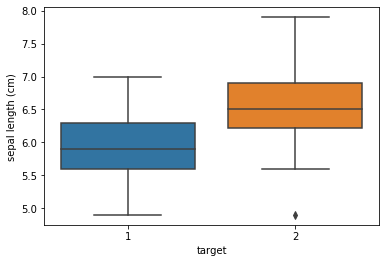

In [13]:
sns.boxplot(x="target", y="sepal length (cm)",data=df_data)

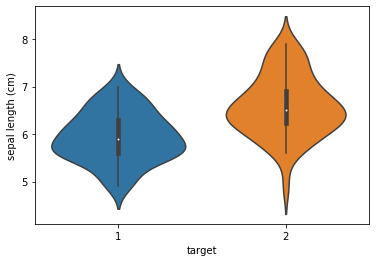

In [14]:
#バイオリンプロット
sns.violinplot(x="target", y="sepal length (cm)",data=df_data)

# 【問題3】前処理・訓練用データと検証用データの分割
前処理の一貫として、訓練用（train）データと検証用（validation）データの分割を行います。今回は訓練用データ75%、検証用データ25%として分割してください。

scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

《注意点》

データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

《分割する理由》

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練用データ、検証に使うデータが検証用データで、一般的に7対3から8対2程度の割合にします。

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(sl_pl),np.array(y), test_size=0.25, random_state=1)

 # 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

《注意点》

標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

《実際の問題での前処理は？》

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [16]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

 # 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練用データです。

sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation

学習が終わった後、検証用データをpredictメソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

In [42]:
for i in [1, 3, 5]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_std, y_train)
    y_train_pred = knn.predict(X_train_std)
    y_test_pred = knn.predict(X_test_std)
    print("train : %.3f (n_neighbors=%d)" % (knn.score(X_train_std, y_train), i))
    print("test : %.3f (n_neighbors=%d)" % (knn.score(X_test_std, y_test), i))

train : 1.000 (n_neighbors=1)
test : 0.880 (n_neighbors=1)
train : 0.960 (n_neighbors=3)
test : 0.920 (n_neighbors=3)
train : 0.947 (n_neighbors=5)
test : 0.920 (n_neighbors=5)


 # 【問題6】評価
検証用データの特徴量を入力して得られた推定値と、検証用データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。

scikit-learnを使い4種類の指標を計算する
混同行列をscikit-learnを使い表示する
4種類の指標値の意味について簡単に調査して文章でまとめる

In [50]:
#正解率
print("正解率　：　%.3f" % accuracy_score(y_test, y_test_pred))
#適合率
print("適合率　：　%.3f" % precision_score(y_test, y_test_pred))
#再現率
print("再現率　：　%.3f" % recall_score(y_test, y_test_pred))
#F値
print("F値　：　%.3f" % f1_score(y_test, y_test_pred))

正解率　：　0.920
適合率　：　0.900
再現率　：　0.900
F値　：　0.900


 # 【問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練用データまたは検証用データを与えます。

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

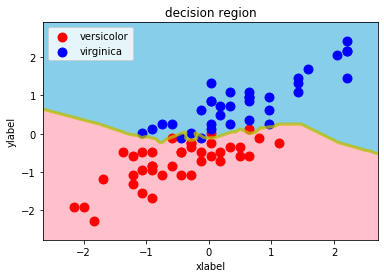

In [55]:
decision_region(X_train_std, y_train, knn)

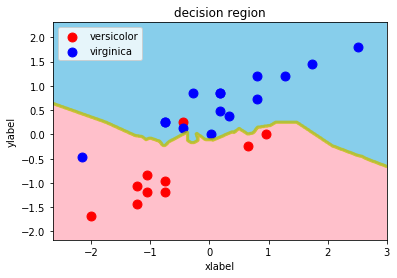

In [56]:
decision_region(X_test_std, y_test, knn)

# 【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

最近傍法
ロジスティック回帰
SVM
決定木
ランダムフォレスト

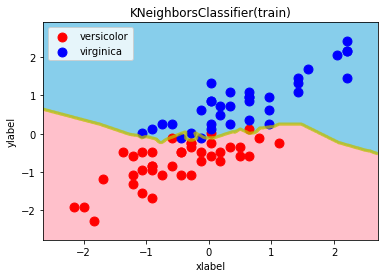

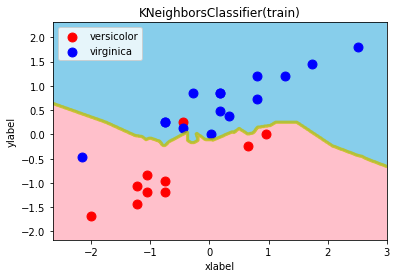

train : 0.947
test : 0.920


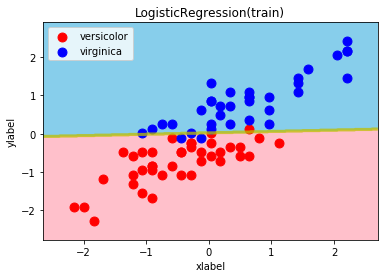

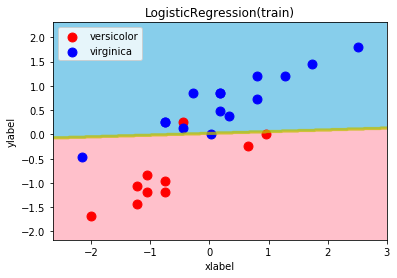

train : 0.947
test : 0.880


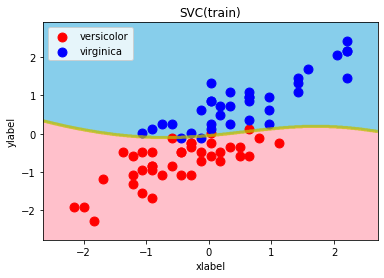

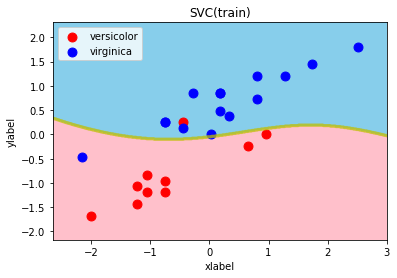

train : 0.947
test : 0.920


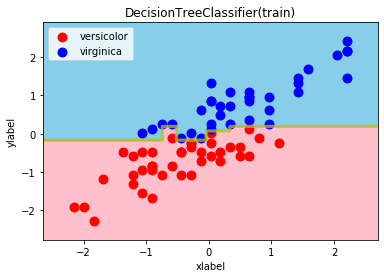

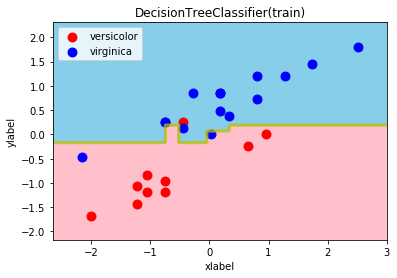

train : 1.000
test : 0.880


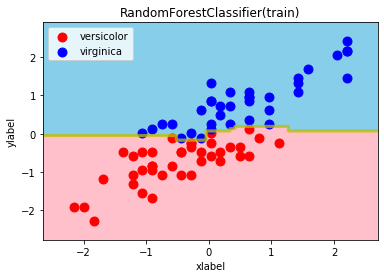

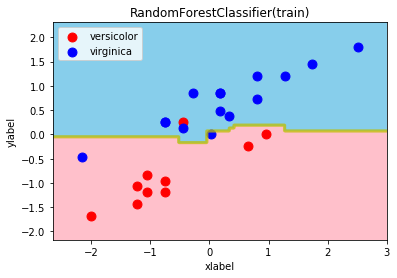

train : 1.000
test : 0.880


In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn .svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


kn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression()
sc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
models = [kn, lr, sc, dt, rf]
model_names = ["KNeighborsClassifier", "LogisticRegression", "SVC", "DecisionTreeClassifier", "RandomForestClassifier"]

for model, model_name in zip(models, model_names):
    model.fit(X_train_std, y_train)
    y_train_pred = model.predict(X_train_std)
    y_test_pred = model.predict(X_test_std)
    decision_region(X_train_std, y_train, model, title=(model_name + '(train)'))
    decision_region(X_test_std, y_test, model, title=(model_name + '(train)'))
    print("train : %.3f" % model.score(X_train_std, y_train))
    print("test : %.3f" % model.score(X_test_std, y_test))
